## Imports and Config

In [107]:
import numpy as np
from tqdm import tqdm
import random

import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
# Learning parameters
GAMMA = 1
ALPHA = 0.5

# get locations of the colored states
env = gym.make("Taxi-v3")
RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC = map(
    lambda x: x[0] * 5 + x[1], env.unwrapped.locs
)
print(RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC)
env.close()

# we'll use these once we have working code
GRID_SIZE = 25
N_PRIMITIVE_MOVES = 4
N_PRIMITIVE_ACTIONS = N_PRIMITIVE_MOVES + 2
N_OPTIONS = 4
N_TOTAL_ACTIONS = N_PRIMITIVE_ACTIONS + N_OPTIONS

0 4 20 23


In [109]:
def epsilonGreedyPolicy(q_value_arr, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(q_value_arr) - 1)
    else:
        return np.argmax(q_value_arr)

In [110]:
class Option:

    def __init__(
        self,
        num_positions: int,
        num_actions: int,
        terminal_position: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_value = np.zeros((num_positions, num_actions))
        self.terminal_position = terminal_position
        self.gamma = gamma
        self.alpha = alpha

    def state_to_position(self, state: int):
        return state // 20

    def get_action(self, state: int, epsilon: float = 0.1):
        position = self.state_to_position(state)
        return epsilonGreedyPolicy(self.q_value[position], epsilon)

    def q_update(self, state: int, action: int, reward: float, next_state: int):
        position = self.state_to_position(state)
        next_position = self.state_to_position(next_state)
        self.q_value[position, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_value[next_position])
            - self.q_value[position, action]
        )

    def check_done(self, state: int):
        return self.state_to_position(state) == self.terminal_position

In [111]:
class HRL:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_values = np.zeros((state_size, action_size))
        self.update_freq = np.zeros((state_size, action_size))
        self.gamma = gamma
        self.alpha = alpha

    def update_primitive(self, state: int, action: int, reward: float, next_state: int):

        self.q_values[state, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [112]:
class SMDP_QLearning(HRL):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)
        self.options = []
        for loc in [RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC]:
            self.options.append(Option(25, 4, loc))

    # def update_option_midway(
    #     self, state: int, action: int, reward: float, next_state: int
    # ):
    #     return

    def update_option_end(
        self, state: int, action: int, reward: float, next_state: int, opt_duration: int
    ):
        self.q_values[state, action] += self.alpha * (
            reward
            + (self.gamma**opt_duration) * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [113]:
class Trainer:

    def __init__(self, env, hrl):
        self.env = env
        self.hrl = hrl
        self.scores_arr = []

    def train(self, num_episodes: int = 1000):

        self.scores_arr = []
        for ep in tqdm(range(num_episodes)):

            state, _ = self.env.reset()
            done = False
            total_reward = 0

            # while episode is not over
            while not done:

                # choose action
                arr = self.hrl.q_values[state][4:]
                action = epsilonGreedyPolicy(arr) + 4

                # if primitive action
                if action < 6:
                    next_state, reward, is_terminal, is_trunc, _ = self.env.step(action)
                    done = is_terminal or is_trunc
                    total_reward += reward
                    self.hrl.update_primitive(state, action, reward, next_state)
                    state = next_state

                # if option
                else:

                    Option = self.hrl.options[action - 6]
                    opt_start_state = state
                    opt_reward, opt_duration, opt_done = 0, 0, Option.check_done(state)
                    opt_action_list = []

                    if opt_done:
                        continue

                    # if opt_start_state == ((0 * 5 + 1) * 5 + 4) * 4 + 0:
                    #     print(
                    #         "Option started at: ",
                    #         opt_start_state,
                    #         "with opt_done: ",
                    #         opt_done,
                    #     )
                    #     print("terminal position is: ", Option.terminal_position)
                        
                    while not opt_done and not done:

                        # choose action
                        opt_action = Option.get_action(state)
                        opt_action_list.append(opt_action)

                        # take action
                        next_state, reward, is_terminal, is_trunc, _ = self.env.step(
                            opt_action
                        )
                        done = is_terminal or is_trunc
                        total_reward += reward

                        # update option's q-values
                        Option.q_update(state, opt_action, reward, next_state)

                        # update reward
                        opt_reward += reward * (self.hrl.gamma**opt_duration)

                        # update q-values of hrl
                        # self.hrl.update_option_midway(
                        #     state, opt_action, reward, next_state
                        # )

                        # update variables
                        opt_duration += 1
                        state = next_state
                        opt_done = Option.check_done(state)

                    # update initial state-action pair, if needed
                    if opt_start_state == ((0 * 5 + 1) * 5 + 4) * 4 + 0:
                        print("Start state is (0,0). ", end="")
                        print(opt_reward)
                        print(opt_action_list)
                        print(np.max(self.hrl.q_values[next_state]))

                    self.hrl.update_option_end(
                        opt_start_state, action, opt_reward, next_state, opt_duration
                    )

                if done:
                    total_reward_arr.append(total_reward)

                # if done and ep % 10 == 0:
                #     print("Reward: ", np.array(total_reward_arr[-10:]).mean())

        # aggregate every 5 elements for smoother plot
        total_reward_arr = np.array(total_reward_arr)
        total_reward_arr = total_reward_arr[: len(total_reward_arr) // 5 * 5].reshape(
            -1, 5
        )
        total_reward_arr = total_reward_arr.mean(axis=1)
        plt.plot(total_reward_arr)

100%|██████████| 10000/10000 [00:07<00:00, 1414.25it/s]


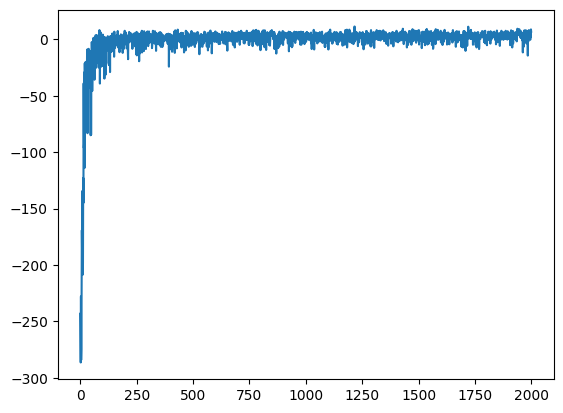

In [114]:
agent = SMDP_QLearning(500, 10)
trainer = Trainer(env, agent)
trainer.train(10000)

<Axes: >

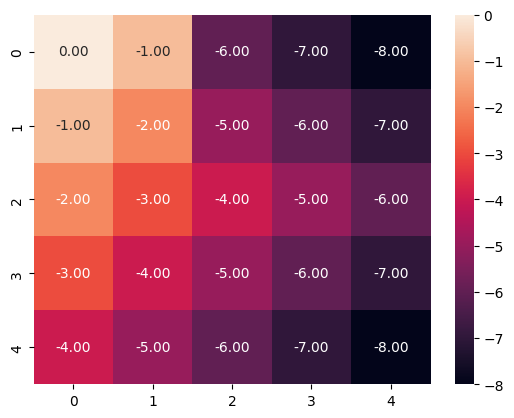

In [115]:
red_grid = agent.options[0].q_value.max(axis=1).reshape(5, 5)  
sns.heatmap(red_grid, annot=True, fmt=".2f")

<Axes: >

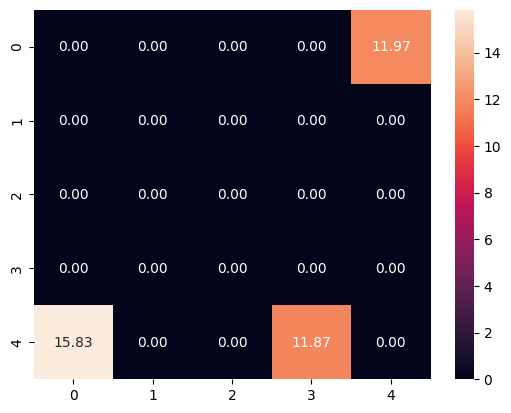

In [116]:
# select every 4th row of q_values and put it into a grid

# desination fixed to be red
grid = agent.q_values[::4]

# passenger is inside car
grid = grid[4::5]

grid = grid[:,6].reshape(5,5)

# plot the grid
sns.heatmap(grid, annot=True, fmt=".2f")